# <b> Classificação Automática de Imagens de Células Sanguíneas usando Redes Neurais Convolucionais </b>

###### <b>Descrição do conjunto de dados:</b> 12.500 imagens de células sanguíneas (JPEG) acompanhadas de rótulos de tipo de célula (CSV). Este conjunto de dados é composto por cerca de 3.000 imagens para cada um dos 4 tipos de células diferentes agrupadas em 4 pastas diferentes (de acordo com o tipo de célula). Os tipos de células são:

<b>1. Eosinófilos<p></b>
<b>2. Linfócitos<p></b>
<b>3. Monócitos<p></b>
<b>4. Neutrófilos<p></b>



# <b>1. Bibliotecas</b>

In [1]:
# Manipulação de arquivos e diretórios
import os
import shutil

# Medição de tempo
import time

# Manipulação de arrays
import numpy as np

# Seleção e avaliação de modelos
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Modelos de redes CNN
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

# Magic command (graficos abaixo das células)
%matplotlib inline

In [2]:
# Dividindo as imagens em treino, validação e teste
def split_dataset(source_folder, destination_folder, number_of_images_por_classe, train_percent, validation_percent, test_percent):
    # Crioa um novo diretório para os dados dividos
    diretorio_a_excluir = destination_folder
    if os.path.exists(diretorio_a_excluir):
        shutil.rmtree(destination_folder)
        print(f"O diretório {diretorio_a_excluir} e suas subpastas foram excluídos com sucesso!")
    
    os.makedirs(destination_folder)
    print(f"O diretório {diretorio_a_excluir} foi criado com sucesso!")
    
    # Criar pastas de destino (TRAIN, VALIDATION, TEST)
    train_folder = os.path.join(destination_folder, 'TRAIN')
    validation_folder = os.path.join(destination_folder, 'VALIDATION')
    test_folder = os.path.join(destination_folder, 'TEST')

    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(validation_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Listar subpastas dentro de source_folder
    subfolders = [f for f in os.listdir(source_folder) if os.path.isdir(os.path.join(source_folder, f))]

    for label in subfolders:
        os.makedirs(os.path.join(train_folder, label), exist_ok=True)
        os.makedirs(os.path.join(validation_folder, label), exist_ok=True)
        os.makedirs(os.path.join(test_folder, label), exist_ok=True)

    for subfolder in subfolders:
        subfolder_path = os.path.join(source_folder, subfolder)
        images = [f for f in os.listdir(subfolder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Embaralhar as imagens aleatoriamente
        random.shuffle(images)

        # Reduzindo o tamanho de cada classe
        images = images[:number_of_images_por_classe]

        # Calcular a quantidade de imagens para TRAIN, VALIDATION e TEST
        total_images = len(images)
        num_train = int(total_images * train_percent)
        num_validation = int(total_images * validation_percent)
        num_test = int(total_images * test_percent)

        # Selecionar imagens aleatórias para TRAIN, VALIDATION e TEST
        train_images = images[:num_train]
        validation_images = images[num_train:num_train + num_validation]
        test_images = images[num_train + num_validation:]

        # Copiar imagens para as pastas TRAIN, VALIDATION e TEST
        for img in train_images:
            src_path = os.path.join(subfolder_path, img)
            dst_path = os.path.join(train_folder, subfolder, img)
            shutil.copy(src_path, dst_path)
            
        for img in validation_images:
            src_path = os.path.join(subfolder_path, img)
            dst_path = os.path.join(validation_folder, subfolder, img)
            shutil.copy(src_path, dst_path)

        for img in test_images:
            src_path = os.path.join(subfolder_path, img)
            dst_path = os.path.join(test_folder, subfolder, img)
            shutil.copy(src_path, dst_path)

In [3]:
source_folder = 'Dataset'
destination_folder = 'Dataset_Divided'

# If you want to change the dataset size, set split as True and edit 
split = True
if split is True:
    number_of_images_per_class = 500
    train_percent = 0.7
    validation_percent = 0.15
    test_percent = 0.15
    
    split_dataset(source_folder, destination_folder, number_of_images_per_class, train_percent, validation_percent, test_percent)

O diretório Dataset_Divided e suas subpastas foram excluídos com sucesso!
O diretório Dataset_Divided foi criado com sucesso!


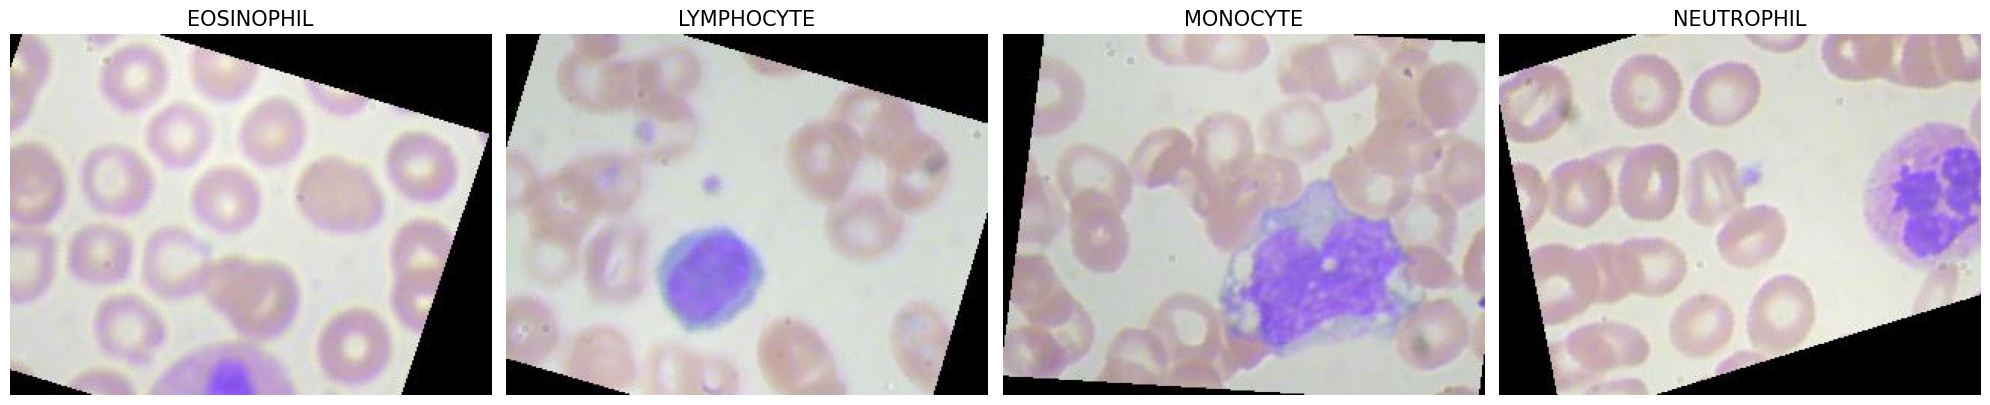

In [4]:
# Parametros para plotagem dos graficos
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

classes = os.listdir(source_folder)

for i, cell_class in enumerate(classes):

  # Imagem aleatória para n-ésima classe
  class_path = os.path.join(source_folder, cell_class)
  images = os.listdir(class_path)
  img_path = os.path.join(class_path, random.choice(images))

  # Carregando a imagem escolhida
  img = plt.imread(img_path)

  # Visualização da imagem para cada classe
  axs[i].imshow(img)
  axs[i].set_title(cell_class, fontsize=15)
  axs[i].axis('off')

plt.tight_layout()
plt.show()

In [5]:
# Definindo a transformação das imagens (Pré-Processamento)
channel_means = [0.66049188, 0.64131908, 0.67861132]
channel_stds = [0.25679409, 0.25947488, 0.2599271]
img_width, img_height = 64, 64

def transformacao_dados(dataset):
    if dataset == "TRAIN":
        transform = transforms.Compose([
        transforms.Resize(size=(img_width, img_height)), # Reduzindo as imagens para  img_width x img_height
        transforms.RandomHorizontalFlip(), # Inversão horizontal aleatória de imagens
        transforms.RandomRotation(degrees=15), # Rotaciona a imagem em 15°
        transforms.ToTensor(), # Converte a imagem no formato de tensor
        transforms.Normalize(mean=channel_means, std=channel_stds)
        ])

    else:
        transform = transforms.Compose([
        transforms.Resize(size=(img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize(mean=channel_means, std=channel_stds)
    ])
    return transform

In [6]:
# Carregando dados
dataloaders = {}
for name in ['TRAIN', 'VALIDATION', 'TEST']:
    dataset = ImageFolder(os.path.join(destination_folder,name),
                          transform=transformacao_dados(name))
    dataloaders[name] = DataLoader(dataset, shuffle=True,
                                   batch_size=32,
                                   num_workers=2)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Definindo a classe da CNN ResNet18
class ResNet18(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNet18, self).__init__()

        resnet18 = models.resnet18(pretrained=False)
        self.features = nn.Sequential(*list(resnet18.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [8]:
# Instanciando o modelo, função de perda (criterion) e otimizador
model = ResNet18(num_classes=4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

C:\Users\marce\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\marce\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [9]:
# Função para calcular a acurácia
def calculate_accuracy(predictions, labels):
    _, predicted = torch.max(predictions, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

In [10]:
# Treinamento e validação da rede
start_time_resnet18 = time.time()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epochs = 50

for epoch in range(epochs):
    model.train()  # Modo de treinamento

    total_loss = 0.0
    total_accuracy = 0.0

    for data, labels in dataloaders['TRAIN']:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calcule a acurácia e adicione à média total
        accuracy = calculate_accuracy(outputs, labels)
        total_accuracy += accuracy

        total_loss += loss.item()

    # Calcule a média da perda e acurácia para o treinamento
    average_loss = total_loss / len(dataloaders['TRAIN'])
    average_accuracy = total_accuracy / len(dataloaders['TRAIN'])

    train_losses.append(average_loss)
    train_accuracies.append(average_accuracy)

    # Validação
    model.eval()  # Modo de avaliação

    total_loss = 0.0
    total_accuracy = 0.0

    with torch.no_grad():
        for data, labels in dataloaders['VALIDATION']:
            outputs = model(data)
            loss = criterion(outputs, labels)

            # Calcule a acurácia e adicione à média total
            accuracy = calculate_accuracy(outputs, labels)
            total_accuracy += accuracy

            total_loss += loss.item()

    # Calcule a média da perda e acurácia para a validação
    average_loss = total_loss / len(dataloaders['VALIDATION'])
    average_accuracy = total_accuracy / len(dataloaders['VALIDATION'])

    val_losses.append(average_loss)
    val_accuracies.append(average_accuracy)

    # Imprima as métricas no final de cada época
    print(f'Época {epoch + 1}/{epochs}, Treinamento - Perda: {train_losses[-1]:.4f}, Acurácia: {train_accuracies[-1] * 100:.2f}%, '
          f'Validação - Perda: {val_losses[-1]:.4f}, Acurácia: {val_accuracies[-1] * 100:.2f}%')

end_time_resnet18 = time.time()

execution_time_resnet18 = end_time_resnet18 - start_time_resnet18
print(f'Tempo de execução: {execution_time_resnet18:.5f} segundos')

Época 1/50, Treinamento - Perda: 1.4573, Acurácia: 27.91%, Validação - Perda: 1.4570, Acurácia: 32.81%
Época 2/50, Treinamento - Perda: 1.2386, Acurácia: 41.71%, Validação - Perda: 2.9135, Acurácia: 38.96%
Época 3/50, Treinamento - Perda: 0.9482, Acurácia: 59.73%, Validação - Perda: 1.5104, Acurácia: 51.88%
Época 4/50, Treinamento - Perda: 0.8289, Acurácia: 62.90%, Validação - Perda: 0.6772, Acurácia: 72.08%
Época 5/50, Treinamento - Perda: 0.7029, Acurácia: 68.68%, Validação - Perda: 0.5921, Acurácia: 69.58%
Época 6/50, Treinamento - Perda: 0.6841, Acurácia: 69.82%, Validação - Perda: 0.5910, Acurácia: 76.98%
Época 7/50, Treinamento - Perda: 0.5889, Acurácia: 72.94%, Validação - Perda: 0.4994, Acurácia: 79.27%
Época 8/50, Treinamento - Perda: 0.5046, Acurácia: 78.31%, Validação - Perda: 1.1781, Acurácia: 65.62%
Época 9/50, Treinamento - Perda: 0.5373, Acurácia: 76.33%, Validação - Perda: 0.6700, Acurácia: 71.56%
Época 10/50, Treinamento - Perda: 0.4647, Acurácia: 79.90%, Validação - P

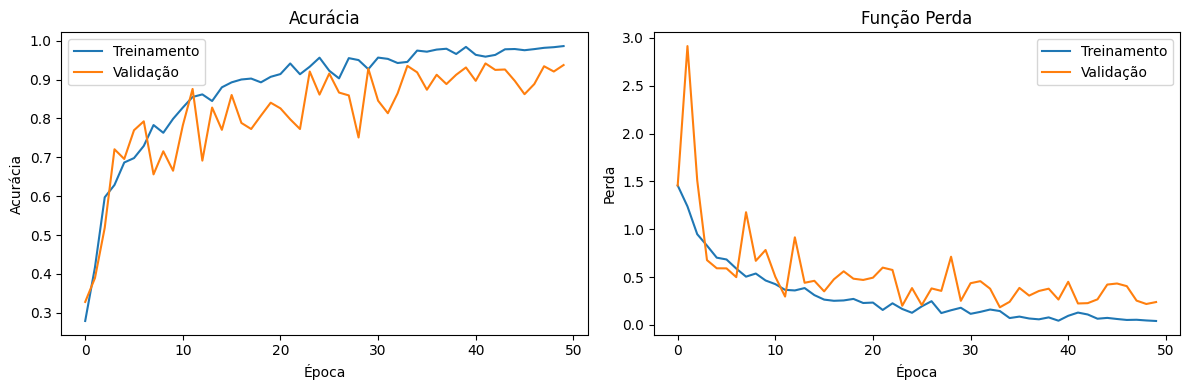

In [13]:
# Plotando gráficos de acurácia e perda
plt.figure(figsize=(12, 4))

# Gráfico de Acurácia
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Treinamento')
plt.plot(val_accuracies, label='Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.title('Acurácia')
plt.legend()

# Gráfico de Perda
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Treinamento')
plt.plot(val_losses, label='Validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('Função Perda')
plt.legend()
plt.tight_layout()
plt.savefig('ResNet18.pdf',
            format='pdf',
            dpi=600,
            transparent=False,
            bbox_inches='tight',
            pad_inches=0.1)
plt.show()

In [12]:
# Avaliando o modelo no conjunto de teste
model.eval()  # Modo de avaliação

correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for data, labels in dataloaders['TEST']:
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

# Calculando a acurácia final
accuracy = correct_predictions / total_samples
print(f'Acurácia no conjunto de teste: {accuracy * 100:.2f}%')

Acurácia no conjunto de teste: 91.67%
